## Data Exploration, Cleanup and Analysis

In [68]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
#Essentials
import numpy as np
import pandas as pd
import pickle

#SQL related
import sqlite3
import pandas.io.sql as pd_sql

#API related
import requests

#Preprocessing
import re
from geotext import GeoText
from calendar import month_name
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

#Sentiment analysis
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


#Essentials
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.pipeline import Pipeline

#Plotting fun
import matplotlib.pyplot as plt
import seaborn as sns

#NLP fun
import nltk
from  collections  import namedtuple

#Text cleaning (stemming, lemmatizing, etc.)
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import inflection
from autocorrect import spell

#Vectorizing
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 

# Dimentionality reduction
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation, PCA

#NLP clustering
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, DBSCAN

#Clustering help
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

#Clustering visualization
from sklearn.manifold import TSNE

#Fun stuff
import pyLDAvis
import pyLDAvis.sklearn


%matplotlib inline

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [70]:
#'/Users/auste_m/ds/metis/metisgh/github/metis_projects/Customer_Review_Sentiment_Analysis/Datasets/twitter-airline-sentiment/database.sqlite'

In [71]:
#Setting up for working with SQLite database
sqlite_file = './Datasets/twitter-airline-sentiment/database.sqlite'

conn = sqlite3.connect(sqlite_file)
cursor = conn.cursor()

In [72]:
#Check one of the rows in the table
preview = cursor.execute("SELECT * FROM Tweets LIMIT 20")
columns = [column[0] for column in preview.description]
print('The columns of the table are:' + ' \n' + str(columns) + '\n')
print('Preview of one of the rows in the table:' + '\n' + str(preview.fetchone()))

The columns of the table are: 
['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']

Preview of one of the rows in the table:
(567588278875213824, 'neutral', 1, '', '', 'Delta', '', 'JetBlueNews', '', 0, "@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Greenfield Daily Reporter http://t.co/LM3opxkxch", '', '2015-02-16 23:36:05 -0800', 'USA', 'Sydney')


In [73]:
#Retrieve relevant information from Tweets table in SQLite database and store them in a pandas dataframe
query = """SELECT airline, retweet_count, text as 'tweet' 
            FROM Tweets"""

tweets_df = pd.read_sql_query(query, conn)

In [74]:
#Sanity check
print(tweets_df.info())
tweets_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14485 entries, 0 to 14484
Data columns (total 3 columns):
airline          14485 non-null object
retweet_count    14485 non-null int64
tweet            14485 non-null object
dtypes: int64(1), object(2)
memory usage: 339.6+ KB
None


,airline,retweet_count,tweet
0,Delta,0,@JetBlue's new CEO seeks the right balance to ...
1,Delta,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...
2,United,0,@united yes. We waited in line for almost an h...
3,United,0,@united the we got into the gate at IAH on tim...
4,Southwest,0,@SouthwestAir its cool that my bags take a bit...


### Put aside a test set

In [75]:
tweets_test = tweets_df[10000:12000]
tweets_train = tweets_df[:10000]
tweets_train = tweets_train.append(tweets_df[12000:])

In [76]:
# with open('./pickles/tweets_test1.pkl', 'wb') as picklefile:
#     pickle.dump(tweets_test, picklefile)

In [77]:
# tweets_train.info()
# tweets_test.info()

### Let's gather airport information from an external API

In [78]:
#First need to get global airport database through an API request 
airport_db_url = 'https://aviation-edge.com/api/public/airportDatabase?key=42e87b-a2f1be-c446fa-06d7a2-012f14'
get_response = requests.get(airport_db_url)
airport_db = get_response.json()

#Then I need to extract the information that is relevant to me (airport names and codes)
airport_info = []

for airport in airport_db:
    airport_info.append(airport['codeIataAirport'])
    airport_info.append(airport['nameAirport'])

#Test that results make sense
# if 'IAH' in airport_codes:
#     print(airport_db[airport_codes.index('IAH')])
# else:
#     print(False)

In [79]:
len(airport_info)

20102

### Let's set up some helped functions

In [7]:
#helper function to remove stuff from tweets

def remove_airline(string):
    """Takes a string as input.
    Returns the same string with hashtag removed."""
    pattern1 = re.compile('@[A-Za-z]+\w')
    new_string = string
    try:
        all_airlines = pattern1.findall(new_string)
        for airline in all_airlines:
            new_string = re.sub(airline, '', new_string)
    except:
        pass
    return new_string

def remove_hashtag(string):
    """Takes a string as input.
    Returns the same string with hashtag removed."""
    pattern2 = re.compile('#\w+')
    new_string = string
    try:
        all_hashtags = pattern2.findall(new_string)
        for hashtag in all_hashtags:
            new_string = re.sub(hashtag, '', new_string)
    except:
        pass
    return new_string


def remove_code(string):
    """Takes a string as input.
    Returns the same string with any capital letter & digit combination text removed."""
    pattern3 = re.compile('[A-Z]?\d+[A-Z]+')
    pattern4 = re.compile('\d+')
    new_string = string
    try:
        codes = pattern3.findall(new_string)
        codes.extend(pattern4.findall(new_string))
        for elem in codes:
            new_string = re.sub(elem, '', new_string)
    except:
        pass
    return new_string
    
    
def remove_url(string):
    """Takes a string as input.
    Returns the same string with any urls removed removed."""
    pattern5 = re.compile('http://t.co/\w+')
    new_string = string
    try:
        urls = pattern5.findall(new_string)
        for url in urls:
            new_string = re.sub(url, '', new_string)
    except:
        pass
    return new_string


def remove_location(string):
    """Takes a string as input.
    Returns a new string with location information removed."""
    new_string = string
    geo_loc = GeoText(string)
    locations = []
    if geo_loc.cities != []:
        locations.extend(geo_loc.cities)
    if geo_loc.countries != []:
        locations.extend(geo_loc.countries)
    try:
        for loc in locations:
            new_string = re.sub(loc, '', new_string)
    except:
        pass
    return new_string
    
    
def remove_month(string):
    """Takes a string as input.
    Returns a new string with month information removed."""
    new_string = string
    all_months = month_name[1:]
    try:
        for word in string.split():
            if word in all_months:
                new_string = re.sub(word, '', new_string)
            else:
                continue
    except:
        pass
    return new_string


def remove_emoji(string):
    """Takes a string as input.
    Returns a new string with emojis removed."""    
    pattern6 = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    new_string = string
    try:
        emojis = pattern6.findall(new_string)
        for emoji in emojis:
            new_string = re.sub(emoji, '', new_string)
    except:
        pass
    return new_string

def remove_airport(string):
    """Takes a string as input.
    Returns a new string with airport codes removed.""" 
    new_string = string
    try:
        for word in string.split():
            if word in airport_info:
                new_string = re.sub(word, '', new_string)
            else:
                continue
    except:
        pass
    return new_string



def get_clean_tweet(string):
    """Takes a string and uses all the cleaning related functions above to remove unnecessary elements.
    Returns a 'clean' string."""
    clean_string = remove_airline(remove_hashtag(remove_code(remove_url(remove_location(remove_month(remove_emoji(remove_airport(string))))))))
    return clean_string


def get_Vader_sentiment(string):
    """Takes a string as input. Uses text processing mashape API to retrieve the sentiment.
    Returns a sentiment label and score (from -1 to 1, negatives signalling negative sentiment).""" 
    SIA = SentimentIntensityAnalyzer()
    total_score = SIA.polarity_scores(string)
    if total_score['compound'] < -0.05:
        sentiment = 'negative'
    elif total_score['compound'] >= 0.2:
        sentiment = 'positive'
    else:
        sentiment = 'neutral'
    polarity = total_score['compound']
    return sentiment


def get_TextBlob_sentiment(string):
    """Takes a string as input. Uses text processing mashape API to retrieve the sentiment.
    Returns a sentiment label and score (from -1 to 1, negatives signalling negative sentiment).""" 
    sentiment_all = TextBlob(string).sentiment
    if sentiment_all.polarity < -0.05:
        sentiment = 'negative'
    elif sentiment_all.polarity >= 0.2:
        sentiment = 'positive'
    else:
        sentiment = 'neutral'
    polarity = sentiment_all.polarity
    return sentiment

def get_sentiment(string):
    """Takes a string, generates sentiment using TextBlob and Vader.
    Returns the final sentiment label based on the two techniques (negative in either => negative)"""
    sentiment_blob = get_TextBlob_sentiment(string)
    sentiment_vader = get_Vader_sentiment(string)
    sentiment = ''
    if sentiment_blob == 'negative' or sentiment_vader == 'negative':
        sentiment = 'negative'
    elif sentiment_blob == 'neutral' or sentiment_vader == 'neutral':
        sentiment = 'neutral'
    else:
        sentiment = 'positive'
    return sentiment

# def get_sentiment_API(string):
#     """Takes a string as input. Uses text processing mashape API to retrieve the sentiment.
#     Returns a sentiment label and score (from -1 to 1, negatives signalling negative sentiment).""" 
#     #API stuff
#     sentiment_API_url = 'https://japerk-text-processing.p.mashape.com/sentiment/'
#     sentiment_API_response = requests.post(sentiment_API_url,
#                                           data={
#                                             "language": "english",
#                                             "text": test_tweet}
#                                               ,
#                                           headers={
#                                             "X-Mashape-Key": "3hN4k8H8Brmsh0Hp4sTefboY6vHpp1qZZ3jjsnvlGiMsNSK59o",
#                                             "Content-Type": "application/x-www-form-urlencoded",
#                                             "Accept": "application/json"}
#                                           )

#     sentiment_all = sentiment_API_response.json()
#     sentiment = sentiment_all['label']
#     neg_prob = sentiment_all['probability']['neg']
#     return (sentiment, neg_prob)

def simple_pos(pos):
    if pos == 'NOUN':
        return 'n'
    elif pos == 'VERB':
        return 'v'
    elif pos == 'ADJ':
        return 'a'
    elif pos == 'ADV':
        return 'r'
    elif pos == 'ADJ_SAT':
        return 's'
    else:
        return 'n'


def process_words(string):
    """Takes a string as input.
    Returns the string after lemmatizing and singularizing the words."""
    processed_string = string
    lmtzr = WordNetLemmatizer()
    word_pos_pair = pos_tag(word_tokenize(processed_string), tagset='universal')
    for word, pos in word_pos_pair:
        word_pos = simple_pos(pos)
        #spell_correct = ' '+spell(word) if "'" in word else spell(word)
        lame_word = lmtzr.lemmatize(word, word_pos)
        singular_word = inflection.singularize(lame_word)
        processed_string = processed_string.replace(word, singular_word)
    return processed_string 


def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def get_issue_name(issue_index):
    """Takes the cluster index.
    Returns the issue name."""
    cluster_name_list = ['Issue with Contacting Customer Service', 'Poor Customer Service', 'Missed Connection', 'Cancellation',
                    'Boarding / Deplaning Issue', 'Rebooking Issues', 'Poor Customer Service / Rebooking Issues', 'Lost Baggage', 'Bad Weather Related',
                    'Poor Customer / Airport Agent Service']
    cluster_index = int(issue_index)
    issue = cluster_name_list[cluster_index]
    return issue
    

### Sentiment labelling

In [81]:
#Are the tweets positive or negative (tried TextBlob.sentiment, TextBlob.NaiveBayesAnalyzer, nltk.Vader, API sentiment analyzer)

test_tweet = tweets_train['tweet'][14063]
label_TB = TextBlob(test_tweet).sentiment
label_NB = TextBlob(test_tweet, analyzer=NaiveBayesAnalyzer()).sentiment

SIA = SentimentIntensityAnalyzer()
total_score = SIA.polarity_scores(test_tweet)
print("Example tweet: '"+ str(test_tweet), "'")
print('Scores using TextBlob default', str(label_TB))
print('Scores using TextBlob Naive Bayes classifier', str(label_NB))
print('Scores using Vader', str(total_score))
# print('Label and negative probability using sentiment API', str(get_sentiment_API(test_tweet)))

Example tweet: '@SouthwestAir need to learn how to treat people with respect and just a little dignity. #FAIL '
Scores using TextBlob default Sentiment(polarity=-0.34375, subjectivity=0.39999999999999997)
Scores using TextBlob Naive Bayes classifier Sentiment(classification='pos', p_pos=0.7744402760303103, p_neg=0.22555972396969037)
Scores using Vader {'neg': 0.0, 'neu': 0.594, 'pos': 0.406, 'compound': 0.8024}


#### Checking the discrepancies between TextBlob and Vader approaches

In [82]:
#Testing different approaches
# tweets_train['sentiment_TextBlob'] = [get_TextBlob_sentiment(tweet)[0] for tweet in tweets_train['tweet']]
# tweets_train['polarity_TextBlob'] = [get_TextBlob_sentiment(tweet)[1] for tweet in tweets_train['tweet']]
# tweets_train['sentiment_Vader'] = [get_Vader_sentiment(tweet)[0] for tweet in tweets_train['tweet']]
# tweets_train['polarity_Vader'] = [get_Vader_sentiment(tweet)[1] for tweet in tweets_train['tweet']]
# tweets_train['sentiment'] = [get_sentiment_API(tweet)[0] for tweet in tweets_train['tweet']]

In [83]:
# tweets_train[(tweets_train['sentiment_TextBlob'] == 'positive') & (tweets_train['sentiment_Vader'] == 'negative')]

In [84]:
# tweets_train[(tweets_train['sentiment_Vader'] == 'positive') & (tweets_train['sentiment_TextBlob'] == 'negative')].sort_values(by='polarity_Vader', ascending=False)

In [85]:
#tweets_train['tweet'][14063]

### Creating a sentiment column

In [86]:
#Adding a column for sentiment label and negative score each
tweets_train['sentiment'] = [get_sentiment(tweet) for tweet in tweets_train['tweet']]

#### I'm only really interested in negative tweets

In [87]:
#Let's filter only on negative tweets (since that is our constructive criticism (or hopefully so))
neg_tweets = tweets_train[tweets_train['sentiment'] == 'negative']
neg_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5192 entries, 1 to 14480
Data columns (total 4 columns):
airline          5192 non-null object
retweet_count    5192 non-null int64
tweet            5192 non-null object
sentiment        5192 non-null object
dtypes: int64(1), object(3)
memory usage: 202.8+ KB


### Let's get sweeping

#### Examining hashtag containing tweets

In [88]:
# #Identify all the tweets containing hashtags
# pattern2 = re.compile('#[A-Za-z]+\w')
# count_hash_tweets = 0

# for index, tweet in enumerate(tweets_train['tweet']):
#     try:
#         h_tweet = pattern2.search(tweet).group()
#         print(index, h_tweet)
#         count_hash_tweets += 1
#     except:
#         continue
        
# print('\nTotal number of tweets containing hashtags =', str(count_hash_tweets))

#### Same for urls

In [89]:
# # Find url pattern
# https_list = []

# for tweet in tweets_train['tweet']:
#     if url_remove(tweet) == []:
#         pass
#     else:
#         https_list.append(url_remove(tweet))
        
# print(https_list)

In [90]:
# #Testing code_remove function
# test_string = tweets_train['tweet'][1582]
# print(test_string)
# print(url_remove(test_string))

> Wooohooo!!!

#### Now it's location time

In [91]:
# madrid_tweet = tweets_train['tweet'][14451]
# geo = GeoText(madrid_tweet)
# geo.cities

In [92]:
#Clean up tweet column, remove the "@word" from the rest of the tweet
# tweets_train['tweet_clean'] = tweets_train['tweet'].apply(remove_airline)

# #Clean up tweet column, remove the hashtags from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_hashtag)

# #Clean up tweet column, remove code-like elements from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_code)

# #Clean up tweet column, remove urls from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_url)

# #Clean up tweet column, remove locations from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_location)

# #Clean up tweet column, remove month names from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_month)

# #Clean up tweet column, remove emojis from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_emoji)

# #Clean up tweet column, remove airport codes and names from all tweets
# tweets_train['tweet_clean'] = tweets_train['tweet_clean'].apply(remove_airport)

In [93]:
#Clean up tweet column, remove codes, hashtags, airline names, urls, locations, etc.
neg_tweets['tweet_clean'] = neg_tweets['tweet'].apply(get_clean_tweet)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Mini moment of truth

In [94]:
#Let's make sure it works (indexes to test = 1, 3, 12805)
print(neg_tweets['tweet'][1], '\n')
print(neg_tweets['tweet_clean'][1], '\n')

print(neg_tweets['tweet'][3], '\n')
print(neg_tweets['tweet_clean'][3], '\n')

print(neg_tweets['tweet'][12805], '\n')
print(neg_tweets['tweet_clean'][12805], '\n')

@JetBlue is REALLY getting on my nerves !! 😡😡 #nothappy 

 is REALLY getting on my nerves !!   

@united the we got into the gate at IAH on time and have given our seats and closed the flight. If you know people is arriving, have to wait 

 the we got into the gate at  on time and have given our seats and closed the flight. If you know people is arriving, have to wait 

@united lots of reports of system failures delaying flights over the last week. Currently sitting on the tarmac at OGG for over an hour. 

 lots of reports of system failures delaying flights over the last week. Currently sitting on the tarmac at  for over an hour. 



In [95]:
neg_tweets.head(10)

,airline,retweet_count,tweet,sentiment,tweet_clean
1,Delta,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,negative,is REALLY getting on my nerves !!
2,United,0,@united yes. We waited in line for almost an h...,negative,yes. We waited in line for almost an hour to ...
3,United,0,@united the we got into the gate at IAH on tim...,negative,the we got into the gate at on time and have...
6,United,0,@united I like delays less than you because I'...,negative,I like delays less than you because I'm the o...
7,United,0,"@united, link to current status of flights/air...",negative,", link to current status of flights/airports? ..."
9,United,0,@united I tried 2 DM it would not go thru... n...,negative,I tried DM it would not go thru... not sure why
16,United,0,@united i have items of sentimental value that...,negative,i have items of sentimental value that I'm he...
17,Southwest,0,@SouthwestAir We have been stuck in SJU for se...,negative,We have been stuck in for several hours and ...
21,United,0,"@United is officially the worst, most delayed,...",negative,"is officially the worst, most delayed, and le..."
22,Southwest,0,@SouthwestAir won't answer their phones #Horri...,negative,won't answer their phones


## Saving (just in case)

In [96]:
# #Pickle the dataset, just in case 
# with open('./pickles/negative_tweets_new.pkl', 'wb') as picklefile:
#     pickle.dump(neg_tweets, picklefile)

### Now to the modelling part!

In [97]:
#Moving forward read from pickle rather than repeat above steps
with open('./pickles/negative_tweets.pkl', 'rb') as picklefile:
    negative_tweets = pickle.load(picklefile)

In [98]:
negative_tweets = negative_tweets.drop(columns=['tweet', 'retweet_count', 'sentiment'])
negative_tweets.head()

,airline,tweet_clean
1,Delta,is REALLY getting on my nerves !!
2,United,yes. We waited in line for almost an hour to ...
3,United,the we got into the gate at on time and have...
6,United,I like delays less than you because I'm the o...
7,United,", link to current status of flights/airports? ..."


In [99]:
#Some prep work (lemmatize)
tweet_col = negative_tweets['tweet_clean']
tweet_col = [process_words(tweet) for tweet in tweet_col]
tweet_col[:10]

[' be REALLY get on my nerve !!  ',
 ' ye. We wait in line for almost an hour to do so. Some passenger just leave not want to wait past be.',
 ' the we get into the gate at  on time and have give our seat and close the flight. If you know person be arrive, have to wait',
 " I like delay less than you because I'm the one on the plane. Connect me with a voucher",
 ", link to current status of flights/airport? Fly BWI-EWR-MCO thi morning yet can't yet tell what any problem be except see snow.",
 ' I try  DM it would not go thru... not sure why',
 " i have item of sentimental value that I'm heartbroken be miss",
 ' We have be stick in  for several hour and no one be answer here. Really tough to  SW. No response be bad.',
 ' be officially the bad, most delay, and least helpful airline I have ever have the mbefortune of fly on',
 " won't answer their phone    "]

In [100]:
#Some prep work (removing some of the most popular, but not indicative words)
stop = stopwords.words('english')
stop += ['.', ',', '(', ')', "'", '"', '!', ':', 'DM', 'dm', 'Dm', 'get', 'amp', 'yes', 'no', 'thi', 'ua', 'go', 'airline', 'every',
         'flight', 'flighting', 'fly', 'flightled', 'flighted', 'flightr', 'flightlation', 'ever', 'never',
         'minute', 'min', 'hour', 'hr', 'day', 'today', 'tonight', 'tomorrow', 'time', 'first', 'last',]
stop = set(stop)

In [101]:
params = {
            'strip_accents': 'ascii',
            'lowercase': True,
            'stop_words': stop, 
            'min_df': 5,
            'ngram_range': (1, 2)
         }

In [102]:
#Need to convert words to vectors, cause the computer doesn't understand words like we, humans, do
count_vec = CountVectorizer(**params)
negative_tweets_cv_viz = count_vec.fit_transform(tweet_col)
negative_tweets_cv = negative_tweets_cv_viz.toarray()
negative_tweets_cv = pd.DataFrame(negative_tweets_cv, columns=count_vec.get_feature_names())
negative_tweets_cv.head()

,00,aa,able,absolute,absolutely,absurd,accept,acceptable,access,accommodate,...,year old,yell,yep,yesterday,yet,yo,youre,yr,yr old,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0


### Dimensionality Reduction

In [103]:
#Number of topics
n_topics = 9
n_words = 7       #originally 5

In [104]:
#Best results were generated by CountVectorizer + NMF
nmf_cv_model = NMF(n_components=n_topics)
nmf_cv_data = nmf_cv_model.fit_transform(negative_tweets_cv)

In [105]:
print('Count vectorizer and NMF:')
display_topics(nmf_cv_model, count_vec.get_feature_names(), n_words)

Count vectorizer and NMF:

Topic  0
service, customer, customer service, terrible, worst, poor, worst customer

Topic  1
cancelled, hold, one, rebook, weather, due, refund

Topic  2
delay, due, miss, connection, delay due, crew, weather

Topic  3
bag, lose, check, still, lose bag, baggage, late

Topic  4
plane, sit, late, leave, one, sit plane, gate

Topic  5
call, back, late, call back, tell, hold, try

Topic  6
bad, weather, experience, make, bad weather, bad experience, thank

Topic  7
problem, booking problem, booking, help, seat, need, reflight

Topic  8
wait, gate, agent, still, gate agent, phone, hold


#### Let's visualize it

In [106]:
nmf_cv_tsne = TSNE(n_components = 2, perplexity = 50.0)
nmf_cv_sne = nmf_cv_tsne.fit_transform(nmf_cv_data)

In [126]:
# plt.figure(dpi=150)  
 
# plt.scatter(nmf_cv_sne[:, 0], nmf_cv_sne[:, 1], alpha=0.5)
# plt.title('tSNE on NMF CV model (topics = 9, words = 7)');

> Not too bad at all!

### Let's save the model and the dimensionally reduced dataset

In [108]:
# with open('./pickles/count_vec_new.pkl', 'wb') as picklefile_cv:
#     pickle.dump(count_vec, picklefile_cv)

# with open('./pickles/nmf_dim_reduction_new.pkl', 'wb') as picklefile_nmf:
#     pickle.dump(nmf_cv_model, picklefile_nmf)

# with open('./pickles/vectorized_dataset_new.pkl', 'wb') as picklefile_d:
#     pickle.dump(nmf_cv_data, picklefile_d)

### Now continue working from the pickle files

In [3]:
with open('./pickles/count_vec.pkl', 'rb') as picklefile_cv:
    count_vec = pickle.load(picklefile_cv)

with open('./pickles/nmf_dim_reduction.pkl', 'rb') as picklefile_nmf:
    nmf_dim_reduction = pickle.load(picklefile_nmf)

with open('./pickles/vectorized_dataset.pkl', 'rb') as picklefile_d:
    vectorized_dataset = pickle.load(picklefile_d)

In [4]:
n_clusters = 10

In [5]:
km_classifier = KMeans(n_clusters = n_clusters, random_state=42)
km_classifier.fit(vectorized_dataset)

final_tsne = TSNE(n_components = 2, perplexity = 50.0)
final_sne = final_tsne.fit_transform(vectorized_dataset)

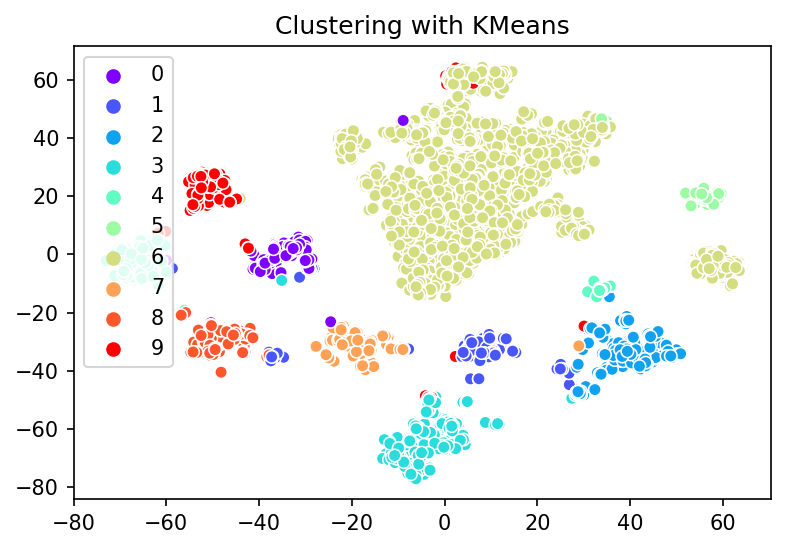

In [10]:
plt.figure(dpi=150)
plt.title('Clustering with KMeans')
sns.scatterplot(final_sne[:, 0], final_sne[:, 1], hue = km_classifier.labels_, legend ='full', palette='rainbow');
# plt.savefig('/Users/auste_m/ds/metis/metisgh/github/metis_projects/Customer_Review_Sentiment_Analysis/tSNE.png', format='png', dpi=120, bbox_inches="tight");

In [11]:
#Topic list in the order displayed after Count Vectorizer and NMF (not corresponding to clusters yet)
topic_list = ['Poor Customer Service', 'Cancellation due to weather', 'Missed Connection', 'Lost Baggage', 'Boarding / Deplaning Issue',
                   'Issue with Contacting Customer Service', 'Bad Weather Related', 'Rebooking Issues', 'Poor Service from Airport Agent(s)']

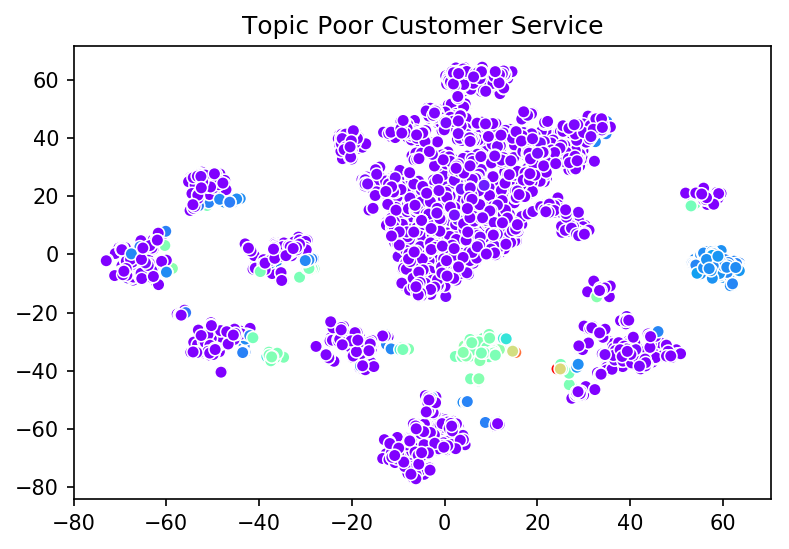

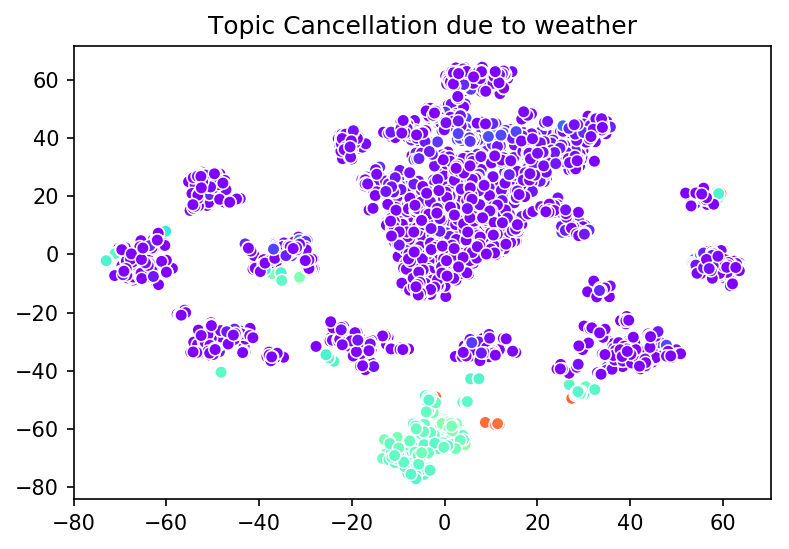

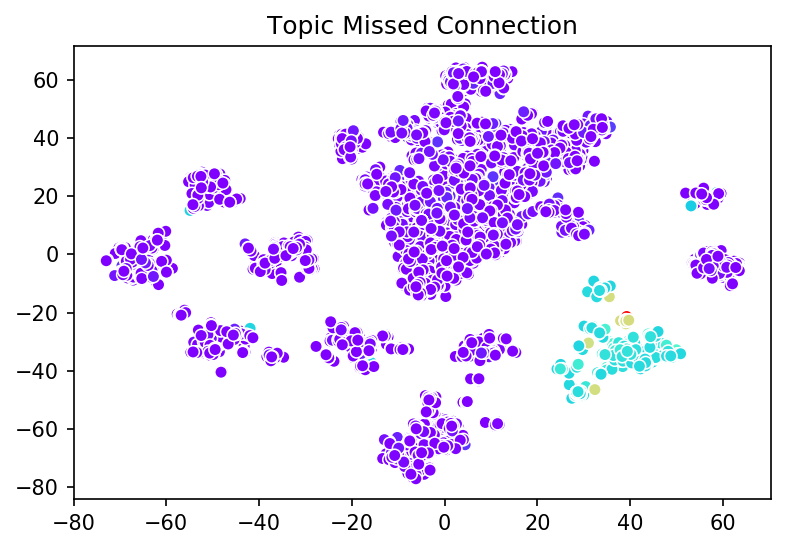

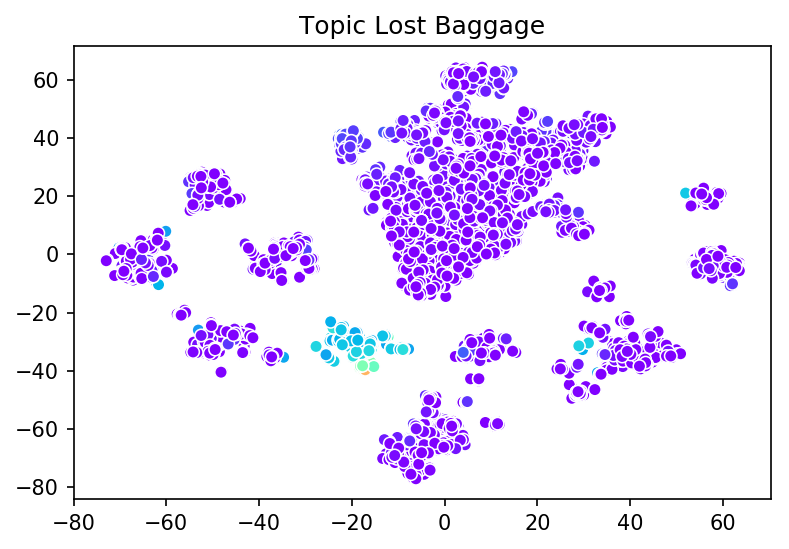

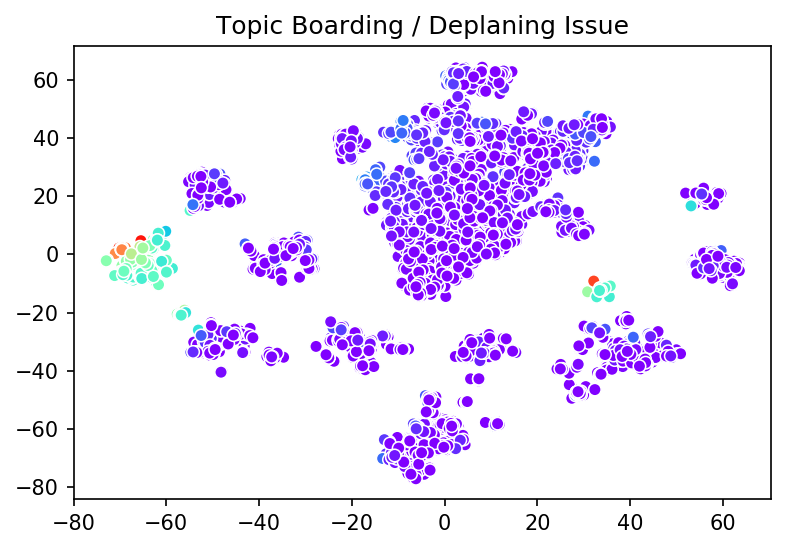

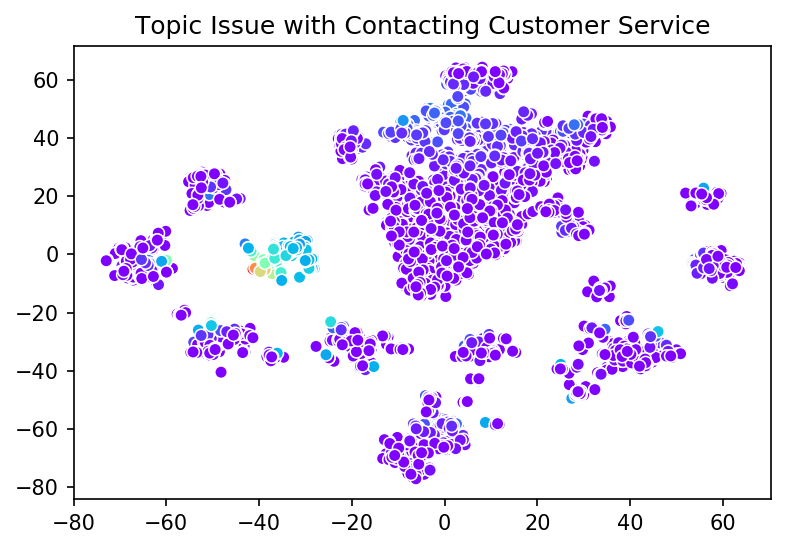

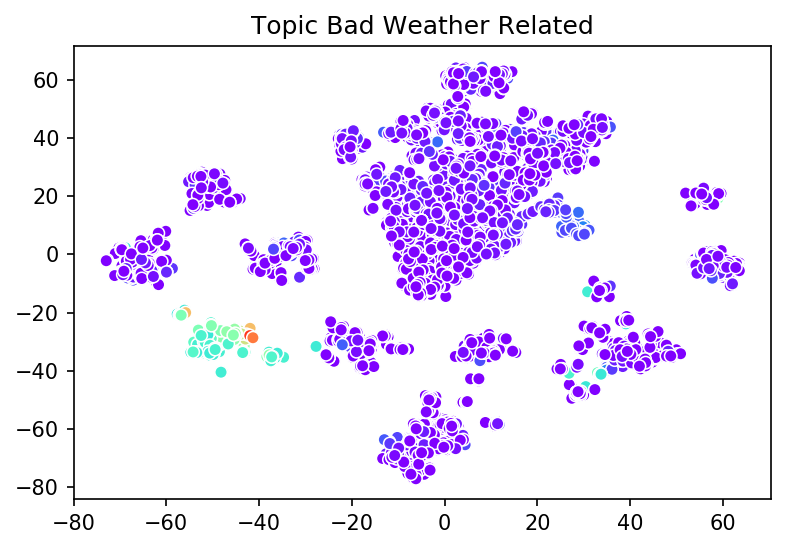

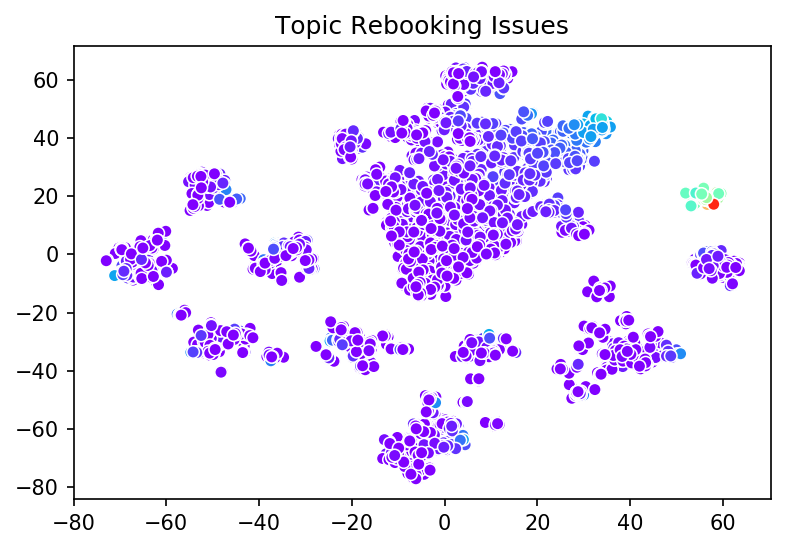

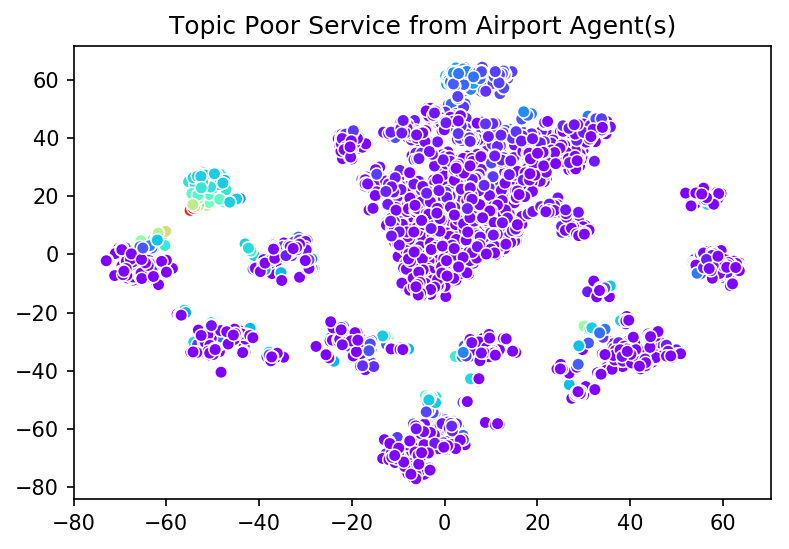

In [12]:
for i in range(9):
    plt.figure(dpi=150)
    sns.scatterplot(final_sne[:, 0], final_sne[:, 1], hue=vectorized_dataset[:,i], legend=None, palette='rainbow')
    plt.title('Topic ' + str(topic_list[i]));

In [13]:
topic_list_in_order = ['Issue with Contacting Customer Service', 'Poor Customer Service', 'Missed Connection', 'Cancellation due to weather',
                       'Poor Customer Service', 'Boarding / Deplaning Issue', 'Rebooking Issues', 'Lost Baggage', 'Bad Weather Related', 
                       'Poor Service from Airport Agent(s)']

### Save the final model

In [14]:
# with open('./pickles/km_classifier_new.pkl', 'wb') as picklefile_c:
#     pickle.dump(km_classifier, picklefile_c)

### Summarize the best model in a function

In [15]:
with open('./pickles/tweets_test.pkl', 'rb') as test_set:
    tweets_test = pickle.load(test_set)

In [16]:
def classify_issue(string):
    """Takes a string (tweet).
    Returns an issue class it belongs to (based on the pretrained model)."""
    with open('./pickles/km_classifier.pkl', 'rb') as model:
        km_classifier = pickle.load(model)
    processed_tweet = process_words(get_clean_tweet(string))
    vectorized_tweet = count_vec.transform([processed_tweet])
    ready_tweet = nmf_dim_reduction.transform(vectorized_tweet)
    issue = km_classifier.predict(ready_tweet)
    return issue

## Et Voila! Let's recommend some actions!

In [19]:
def make_suggestion(string):
    """Takes a string, puts it through a pipeline of actions:
            1. Defines the sentiment (if NOT negative, returns 'You have a happy customer')
            2. Cleans the string (removes codes, hashtags, emojis, airlines, etc.)
            3. Processes words (lemmatization, singularization, etc.)
            4. Classifies into one of ... topics"""
    #Defining an action for each issue
    action_dict = {'Poor Customer Service': 'Please Improve Customer Service Rep Training \U0001F61E',
                  'Cancellation': "Please Minimize Cancellation (when in your control) \u26D4",
                   'Missed Connection': "Please Improve Your Scheduling \U0001F553",
                   'Lost Baggage': "Please Pay More Attention at Baggage Handling \U0001F45C",
                   'Boarding / Deplaning Issue': 'Please Work on Your Boarding Process \u2708',
                   'Issue with Contacting Customer Service': "Please Improve Customer Service Accessibility \u260E",
                   'Bad Weather Related': "Weather Is Out of Your Control, Relax \U0001F4A8",
                   'Rebooking Issues': "Please Improve Your Rebooking Process \U0001F3AB",
                   'Poor Customer Service / Rebooking Issues': 'Please Work On Training Your Airport / On Board Staff \u2708 \U0001F46B'}
    
    sentiment = get_sentiment(string)
    if sentiment != 'negative':
        return 'Keep up the good work! \U0001F44D'
    else:
        issue_index = classify_issue(string)
        issue = get_issue_name(issue_index)
        action = action_dict[issue]
    
    #Now finally choose the action
    return action
    

In [23]:
random_test_tweet = tweets_test.iloc[np.random.choice(len(tweets_test))]['tweet']
print('Test tweet is: "' + str(random_test_tweet) + '"')
print('The model suggests you to: ' + str(make_suggestion(random_test_tweet)))

Test tweet is: "@AmericanAir I am still waiting for that call back. Stranded and no one to talk to"
The model suggests you to: Please Improve Customer Service Accessibility ☎


In [21]:
tweet_example1 = "@United I've never had such a bad customer service"
print('Tweet example: '+ str(tweet_example1))
print('The model suggests you to: ' + str(make_suggestion(tweet_example1)))

Tweet example: @United I've never had such a bad customer service
The model suggests you to: Please Improve Customer Service Rep Training 😞
